In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
## Dataset Things

from data.volumes import Volume, Page, Line
from data.graphset import Graphset
from data.graph_sampler import GraphSampler, AttributeSampler
from data.image_dataset import ImageDataset


import torch_geometric.utils as tutils


import data.volumes as dv

## Model Things
from models import gnn_encoders as gnn
from models import visual_encoders as cnn
from models import edge_visual_encoders as EVE
from models.graph_construction_model import MMGCM


### Utils
import utils 
import visualizations as visu


## Pipelines
import pipelines as pipes

## tasks
from tasks import record_linkage as rl

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torch
import torch.functional as F
import numpy as np
import requests
import cv2
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


from typing import *
from torch.utils.data import DataLoader


/home/soteria/miniconda3/envs/tfm/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/soteria/miniconda3/envs/tfm/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/soteria/miniconda3/envs/tfm/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## Hydra Configuration

In [3]:
overrides = [
    "data.dataset.path=../data/CED/SFLL",
    "models.edge_visual_encoder.add_attention=True",
    "models.add_language=False",    
]

In [4]:
with initialize(version_base="1.3.2", config_path="./configs"):
    CFG = compose(config_name="eval", overrides=["data.dataset.path=../data/CED/SFLL"], return_hydra_config=True)
    


In [5]:
CFG_MODELS = CFG.models
CFG_DATA = CFG.data
CFG_SETUP    = CFG.setup

In [6]:
#! The utility of this dictionary is to relate the groundtruth with the visual information AD-HOC
pk = {"Noms_harmo":"nom", "cognom1_harmo":"cognom_1", "cognom2_harmo":"cognom_2", "parentesc_har":"parentesc", "ocupacio":"ocupacio"}

#  ^ Hydra things

batch_size = CFG_DATA.collator.batch_size
shuffle = CFG_DATA.collator.shuffle
number_volum_years = len(CFG_DATA.dataset.volumes) 
checkpoint_name = CFG_MODELS.name_checkpoint
# ^ 

In [7]:
CFG_DATA.dataset.path
checkpoint_name

'MMGC_Experiment_1_New_Edge_PE_Attention/MMGC_Experiment_1_New_Edge_PE_Attention_train_199'

## Extract the Data

In [8]:
## & Extract the dataset and the information in this case 
volumes = pipes.load_volumes(cfg=CFG_DATA) 
image_dataset = ImageDataset(Volumes=volumes, cfg=CFG_DATA.dataset)
df_transcriptions = image_dataset._total_gt
n_different_individuals = image_dataset._total_individual_nodes
graphset = Graphset(total_nodes=n_different_individuals,
                    df_transcriptions=df_transcriptions,
                    n_volumes=len(volumes),
                    graph_configuration=CFG_DATA.graph_configuration,
                    auxiliar_entities_pk = pk)

sampler = AttributeSampler(graph=graphset._graph, batch_size=batch_size, shuffle=shuffle)


print("Generating DataLoader")

total_loader = DataLoader(dataset=image_dataset, 
                        batch_size = batch_size,
                        collate_fn=image_dataset.collate_fn,
                        num_workers=0,
                        shuffle=True,
                        pin_memory=True)

print("DATA LOADED SUCCESFULLY")

STARTING DOWNLOADING VOLUMES: VOLUME- ../data/CED/SFLL/1889
050000120052048,0014.jpg
050000120052048,0031.jpg
050000120052048,0060.jpg
050000120052048,0061.jpg
050000120052048,0074.jpg
050000120052048,0082.jpg
050000120052048,0088.jpg
050000120052048,0091.jpg
STARTING DOWNLOADING VOLUMES: VOLUME- ../data/CED/SFLL/1906
050000120052053,0007.jpg
050000120052053,0022.jpg
050000120052053,0058.jpg
050000120052053,0059.jpg
050000120052053,0111.jpg
STARTING DOWNLOADING VOLUMES: VOLUME- ../data/CED/SFLL/1910
050000120052054,0007.jpg
050000120052054,0021.jpg
050000120052054,0032.jpg
050000120052054,0035.jpg
050000120052054,0040.jpg
050000120052054,0055.jpg
050000120052054,0068.jpg
050000120052054,0073.jpg
STARTING DOWNLOADING VOLUMES: VOLUME- ../data/CED/SFLL/1915
050000120052055,0007.jpg
050000120052055,0008.jpg
050000120052055,0012.jpg
050000120052055,0013.jpg
050000120052055,0015.jpg
050000120052055,0031.jpg
050000120052055,0037.jpg
050000120052055,0048.jpg
050000120052055,0074.jpg
0500001200

Generating Adj for attributes: 462it [00:00, 822.07it/s] 
Generating Adj for attributes: 1086it [00:00, 4289.30it/s]
Generating Adj for attributes: 1338it [00:00, 2449.79it/s]
Generating Adj for Same As: 5486it [00:00, 42903.24it/s]
Generating Adj for families: 3045it [00:00, 19983.72it/s]

Generating DataLoader
DATA LOADED SUCCESFULLY


## Get Image Example to make the grad cam

In [9]:
IMAGE_PATH = "../data/CED/SFLL/1889/050000120052048,0002/row_0.jpg"
image = Image.open(IMAGE_PATH)

In [10]:
image

In [11]:
image = np.array(image)/255
image = image[:,:736, :]

In [12]:
image = np.resize(image, new_shape=(48, 736, 3))

In [13]:
image.shape

(48, 736, 3)

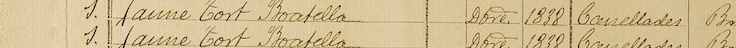

In [14]:
Image.fromarray((image * 255).astype(np.uint8))

## Load Model

In [9]:
## Model Things
from models import gnn_encoders as gnn
from models import visual_encoders as cnn
from models import edge_visual_encoders as EVE
from models.graph_construction_model import MMGCM


H = image_dataset.general_height 
W = image_dataset.general_width // 16

CFG_MODELS.edge_visual_encoder.input_atention_mechanism = H*W

model = MMGCM(visual_encoder=cnn.LineFeatureExtractor, gnn_encoder=gnn.AttributeGNN, edge_encoder=EVE.EdgeAttFeatureExtractor, cfg=CFG_MODELS).to(device)
model_name = f"../checkpoints/{checkpoint_name}.pt"
name_embeddings = f"{checkpoint_name}"

model.load_state_dict(torch.load(model_name))
model.to(device)
print("MODEL LOADED SUCCESFULLY")

MODEL LOADED SUCCESFULLY


## Extracting the embeddings (They must be generated before)

In [10]:
print("EXTRACTING LANGUAGE EMBEDDINGS")
filepath  = f"../embeddings/language_embeddings_{number_volum_years}_entities_{len(CFG_SETUP.configuration.compute_loss_on)}.pkl"
language_embeddings = utils.read_pickle(filepath)

print("EXTRACTING VISUAL EMBEDDINGS")
attribute_embeddings = utils.read_pickle(filepath=f"../embeddings/{name_embeddings}.pkl")
attribute_embeddings = attribute_embeddings.cpu()


print("Embeddings Loaded Succesfully")

core_graph = graphset._graph
core_graph.x_language = language_embeddings
core_graph.epoch_populations = image_dataset._population_per_volume

EXTRACTING LANGUAGE EMBEDDINGS
EXTRACTING VISUAL EMBEDDINGS
Embeddings Loaded Succesfully


In [11]:
map_invers_ocr = {v:k for k,v in image_dataset._map_ocr.items()}

In [12]:
language_embeddings = torch.tensor(np.array(language_embeddings))

In [50]:
language_embeddings.unsqueeze(0).shape

torch.Size([1, 2948, 128])

In [51]:
langua_nearest_negiboors, distances = utils.extract_intra_cluster_nearest_neighboors_at_k(language_embeddings.unsqueeze(1), 50)

In [52]:
print(image_dataset._map_ocr["francisco de a"])
example = image_dataset._map_ocr["francisco de a"]

762


In [53]:
for i in langua_nearest_negiboors[0][example]:
    print(map_invers_ocr[i])

print(map_invers_ocr[example])

urdampilleta
serra
nisart
grases
cordero
toll
mura
canela
mur
rabasa
quiteria
escobet
barquet
amart
fontsere
de letien
cumellas
claramnunt
berdague
clave
vacarisas
idefonso
oriols
ma de los angeles
vines
poch
tamon
alujas
ribera
miserachs
ma de la asuncion
campos
busquets
balta
volta
murgui
cinteta
ricart
ortiz
ignasia
briquets
ma teresa
turne
clara
jose mª
clemente
m presentacion
flores
chisver
ferran
francisco de a


In [54]:
#print((language_embeddings)[148])
#print((language_embeddings)[102])
print(image_dataset._map_ocr["francisco"])
print(torch.nn.functional.cosine_similarity(language_embeddings[example].unsqueeze(0) , language_embeddings[830].unsqueeze(0)))
print(torch.nn.functional.cosine_similarity(language_embeddings[example].unsqueeze(0) , language_embeddings[1251].unsqueeze(0)))



1874
tensor([0.5153])
tensor([0.5362])


In [13]:
core_graph["cognom_1"].map_attribute_index["palet"]

array([  334,   359,  1657,  1706,  1708,  1709,  1710,  1711,  1712,
        1713,  3489,  3510,  3620,  4571,  5512,  5513,  5514,  5515,
        5516,  5517,  5518,  7065,  7125,  7127,  7128,  7130,  7131,
        7132,  8061,  8126,  8127,  8128,  8129,  8130, 10020, 10021,
       10022, 10023, 11089, 11157, 11159, 11160, 11161, 11163, 11164,
       11165, 11166])

In [56]:
core_graph["cognom_1"].map_attribute_index

{'abadia': array([  504,   506,  1535,  1847,  1849,  1850,  1851,  1912,  1914,
         1915,  1916,  2916,  2917,  2918,  3475,  3477,  3756,  4663,
         4665,  4666,  4775,  4776,  4777,  5291,  5453,  5455,  5456,
         5457,  5458,  5459,  5460,  5461,  8326,  8327,  8916,  9052,
         9054,  9055,  9056,  9057,  9058,  9059,  9060,  9061,  9306,
         9332, 10271, 10272, 10933, 10935, 10936, 12094, 12096, 12097,
        12098, 12099, 12100, 12101, 12102, 12103, 12566, 13260, 13261,
        13672, 13673, 13674, 13675, 13676]),
 'abat': array([ 3435,  6922, 10884, 13111]),
 'abella': array([ 7019,  7021,  7022,  8933,  8935, 13589, 13740]),
 'abril': array([10168]),
 'adam': array([ 2517,  2519,  2520,  2521,  2522, 11685]),
 'adelantado': array([ 8645, 11322]),
 'aguilera': array([ 2107,  2109,  2110,  2987,  3096,  4667,  4669,  4670,  6440,
         7444,  7446,  7447, 11564, 11566, 11567]),
 'agullo': array([   74,    76,    77,   599,  5046,  5048,  5050,  5051, 

In [57]:
core_graph["cognom_2"].map_attribute_index

{'abadal': array([ 3576, 13727]),
 'abadia': array([ 1536,  3470,  5292,  7567,  8917, 11736, 12567]),
 'abarca': array([3650]),
 'abat': array([13112, 13113, 13114, 13115]),
 'abella': array([ 8934,  9843, 10207, 12606, 13741, 13742]),
 'acien': array([ 9870, 10747]),
 'adam': array([ 3754, 11686]),
 'adelantado': array([ 8646,  8647,  8648,  8649,  8650,  8651,  8652,  8653, 11323,
        11324, 11325, 11326, 11327, 11328, 11329, 11330]),
 'agramunt': array([12654]),
 'agreda': array([6887]),
 'aguilar': array([ 4990,  6426, 10484, 12885]),
 'aguilera': array([ 318, 3831]),
 'aguilo': array([ 5954, 13067]),
 'agullana': array([5268]),
 'agullo': array([ 5149,  5150,  5151,  8798,  8799,  8800, 12452, 12453]),
 'agusti': array([ 3512, 11337]),
 'agut': array([12244]),
 'aiguader': array([  368,  4277,  7503,  7705, 11854]),
 'alabal': array([13046, 13048]),
 'albacete': array([12874]),
 'albages': array([12985]),
 'albaladejo': array([11418, 12875]),
 'albalat': array([ 2967,  2968, 

## Define the Concept Layer

In [16]:
class SimilarityToConcept():
    
    
    def __init__(self,  comparer_embedding, specfic_attribute):
        self._comparer_embedding = comparer_embedding.to(device)
        self._comparer_attribute = specfic_attribute
        
        
    def __call__(self, model_outputs):
        (attributes)= model_outputs[0]
        embedding_to_compare = attributes[self._comparer_attribute, :]
        euclidean_distance = torch.cdist(embedding_to_compare[None], self._comparer_embedding[None], p=2)

        return euclidean_distance

In [17]:
core_graph["cognom_1"].map_attribute_index["palet"]

array([  334,   359,  1657,  1706,  1708,  1709,  1710,  1711,  1712,
        1713,  3489,  3510,  3620,  4571,  5512,  5513,  5514,  5515,
        5516,  5517,  5518,  7065,  7125,  7127,  7128,  7130,  7131,
        7132,  8061,  8126,  8127,  8128,  8129,  8130, 10020, 10021,
       10022, 10023, 11089, 11157, 11159, 11160, 11161, 11163, 11164,
       11165, 11166])

## Grad Cam

In [101]:
target_layers = [model._edge_encoder._conv3]
targets = [SimilarityToConcept(comparer_embedding=attribute_embeddings[504][0].cuda(), specfic_attribute=0)]
#language_embeddings[669]
reference_image = image_dataset[5512]
reference_image[0].shape

#145

torch.Size([3, 48, 736])

In [102]:
reference_image[1]

tensor([1148, 2436, 1207])

In [103]:
core_graph["cognom_1"].map_index_attribute[10023]

'palet'

In [104]:
# Assuming image_line is a tensor
def unnormalize(image_line, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape to match the channel dimensions
    std = torch.tensor(std).view(3, 1, 1)
    image_line = image_line * std + mean  # Unnormalize
    return image_line

# Unnormalize the image
unnormalized_image = unnormalize(reference_image[0])

# Plot or display the image (make sure to convert to numpy and uint8 if necessary)
unnormalized_image = unnormalized_image.permute(1, 2, 0).numpy()  # Convert to HWC for plotting


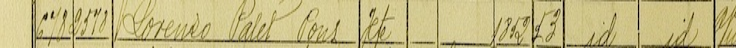

In [105]:
Image.fromarray((unnormalized_image * 255).astype(np.uint8))

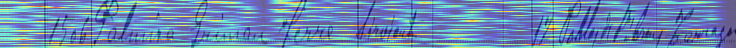

In [90]:
# Where is the car in the image
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=reference_image[0][None],
                        targets=targets)[0, :]
car_cam_image = show_cam_on_image((unnormalized_image), car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)